In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Sun Aug 27 17:33:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   24C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [4]:
n_mels = 1024
n_outputs = 61
n_frames = 400

### Model

In [5]:
from model.model_conditional_transformer_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, h_dim=512, out_dim=n_outputs, n_layers=12)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [6]:
save_dir = '/data/scpark/save/lips/train08.27-3/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 130000, model, None, optimizer)

total 0


### Dataset

In [7]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [8]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [9]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


In [10]:
from torchaudio.transforms import Resample
resample = Resample(24000, 16000).to(device)

def get_states(wav, size, layer=24):
    # 24k to 16k
    wav = resample(wav)
    # Get probs.
    with torch.no_grad():
        states = wav2vec(wav, output_hidden_states=True).hidden_states[layer].transpose(1, 2)
    # Resizing
    states = F.interpolate(states, size=size, mode='linear').detach()
    return states


test : 0 0.8297060132026672
test : 1 0.8236803412437439
test : 2 0.8222183585166931
test : 3 0.8261231780052185
test : 4 0.8193253874778748
test : 5 0.8360946178436279
test : 6 0.81449955701828
test : 7 0.8165355324745178
test : 8 0.818221926689148
test : 9 0.8089743852615356
test_loss : 0.821537971496582


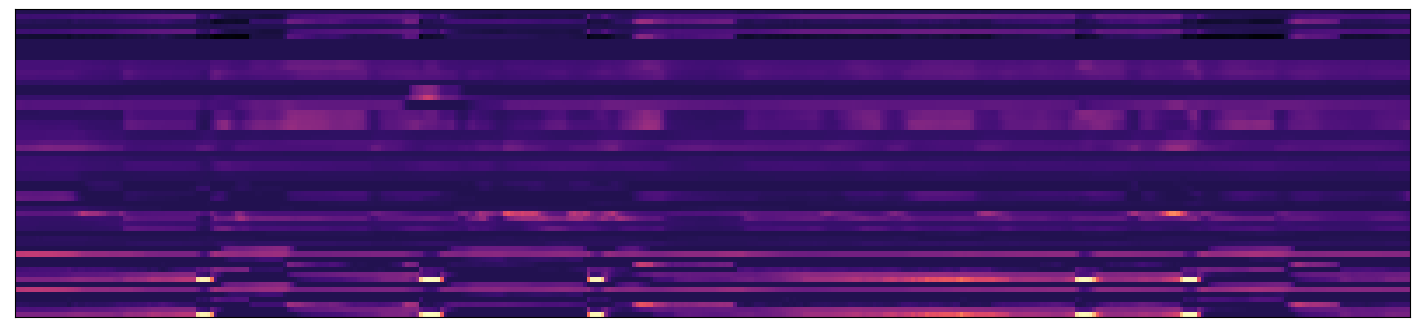

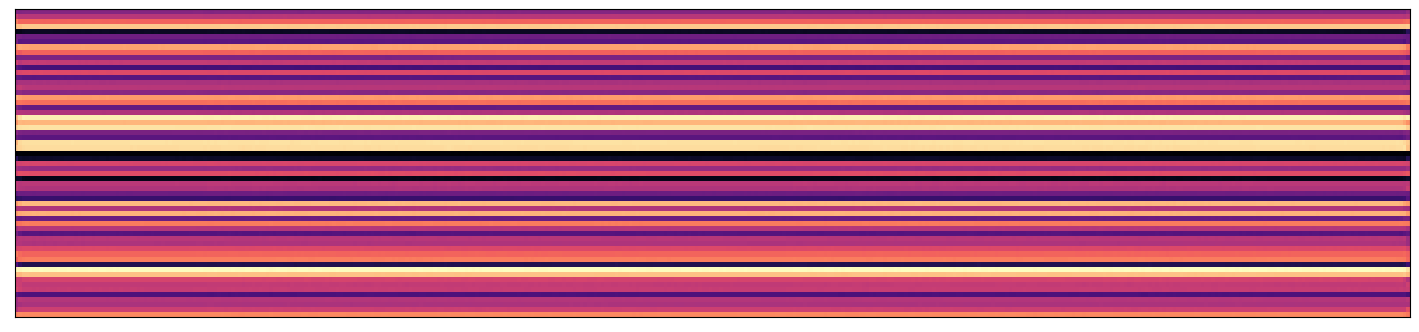

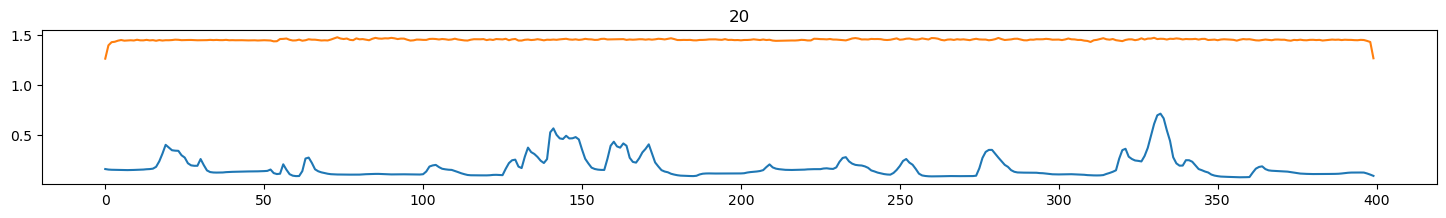

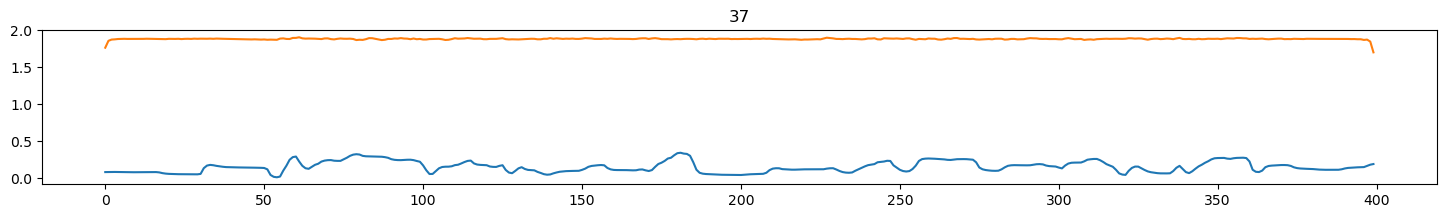

saved /data/scpark/save/lips/train08.27-3/save_0
1
loss 0.8151968121528625
1 0.8151968121528625
2
loss 0.48017755150794983
2 0.48017755150794983
3
loss 0.3025725185871124
3 0.3025725185871124
4
loss 0.22342729568481445
4 0.22342729568481445
5
loss 0.1888970285654068
5 0.1888970285654068
6
loss 0.18936999142169952
6 0.18936999142169952
7
loss 0.18716749548912048
7 0.18716749548912048
8
loss 0.16592974960803986
8 0.16592974960803986
9
loss 0.15354765951633453
9 0.15354765951633453
10
loss 0.1395627111196518
10 0.1395627111196518
11
loss 0.14292337000370026
11 0.14292337000370026
12
loss 0.1425405591726303
12 0.1425405591726303
13
loss 0.14002294838428497
13 0.14002294838428497
14
loss 0.13201183080673218
14 0.13201183080673218
15
loss 0.12715955078601837
15 0.12715955078601837
16
loss 0.12479232996702194
16 0.12479232996702194
17
loss 0.12404409050941467
17 0.12404409050941467
18
loss 0.12310052663087845
18 0.12310052663087845
19
loss 0.12302615493535995
19 0.12302615493535995
20
loss 0.

159 0.08166097104549408
160
loss 0.0806879997253418
160 0.0806879997253418
161
loss 0.08078911155462265
161 0.08078911155462265
162
loss 0.0780966579914093
162 0.0780966579914093
163
loss 0.0793050080537796
163 0.0793050080537796
164
loss 0.08280423283576965
164 0.08280423283576965
165
loss 0.07766353338956833
165 0.07766353338956833
166
loss 0.08080966770648956
166 0.08080966770648956
167
loss 0.07840339839458466
167 0.07840339839458466
168
loss 0.07924308627843857
168 0.07924308627843857
169
loss 0.07807044684886932
169 0.07807044684886932
170
loss 0.07954294234514236
170 0.07954294234514236
171
loss 0.08012759685516357
171 0.08012759685516357
172
loss 0.07504831999540329
172 0.07504831999540329
173
loss 0.07919153571128845
173 0.07919153571128845
174
loss 0.07629904896020889
174 0.07629904896020889
175
loss 0.07736619561910629
175 0.07736619561910629
176
loss 0.07424014806747437
176 0.07424014806747437
177
loss 0.07882948219776154
177 0.07882948219776154
178
loss 0.07437385618686676

315
loss 0.06899623572826385
315 0.06899623572826385
316
loss 0.06385716050863266
316 0.06385716050863266
317
loss 0.062132466584444046
317 0.062132466584444046
318
loss 0.06734252721071243
318 0.06734252721071243
319
loss 0.06453242897987366
319 0.06453242897987366
320
loss 0.0670948326587677
320 0.0670948326587677
321
loss 0.06839761883020401
321 0.06839761883020401
322
loss 0.06232501566410065
322 0.06232501566410065
323
loss 0.06594957411289215
323 0.06594957411289215
324
loss 0.06482009589672089
324 0.06482009589672089
325
loss 0.06544777005910873
325 0.06544777005910873
326
loss 0.0680239349603653
326 0.0680239349603653
327
loss 0.06652569770812988
327 0.06652569770812988
328
loss 0.06296730041503906
328 0.06296730041503906
329
loss 0.06555173546075821
329 0.06555173546075821
330
loss 0.06483921408653259
330 0.06483921408653259
331
loss 0.0644703358411789
331 0.0644703358411789
332
loss 0.0647415965795517
332 0.0647415965795517
333
loss 0.06240106746554375
333 0.06240106746554375

468 0.057926423847675323
469
loss 0.0584019310772419
469 0.0584019310772419
470
loss 0.05823829025030136
470 0.05823829025030136
471
loss 0.05624455586075783
471 0.05624455586075783
472
loss 0.05621982738375664
472 0.05621982738375664
473
loss 0.05610780790448189
473 0.05610780790448189
474
loss 0.05987442284822464
474 0.05987442284822464
475
loss 0.05797092989087105
475 0.05797092989087105
476
loss 0.058700237423181534
476 0.058700237423181534
477
loss 0.05102087929844856
477 0.05102087929844856
478
loss 0.05309149995446205
478 0.05309149995446205
479
loss 0.05787128210067749
479 0.05787128210067749
480
loss 0.05525458604097366
480 0.05525458604097366
481
loss 0.052129145711660385
481 0.052129145711660385
482
loss 0.05588126927614212
482 0.05588126927614212
483
loss 0.053477514535188675
483 0.053477514535188675
484
loss 0.05534952133893967
484 0.05534952133893967
485
loss 0.05579846352338791
485 0.05579846352338791
486
loss 0.05353691801428795
486 0.05353691801428795
487
loss 0.057539

622 0.05198823660612106
623
loss 0.04773576557636261
623 0.04773576557636261
624
loss 0.050711434334516525
624 0.050711434334516525
625
loss 0.05530118942260742
625 0.05530118942260742
626
loss 0.0475953035056591
626 0.0475953035056591
627
loss 0.053087249398231506
627 0.053087249398231506
628
loss 0.051450517028570175
628 0.051450517028570175
629
loss 0.052041396498680115
629 0.052041396498680115
630
loss 0.05336586758494377
630 0.05336586758494377
631
loss 0.05076209455728531
631 0.05076209455728531
632
loss 0.04650534689426422
632 0.04650534689426422
633
loss 0.04847016558051109
633 0.04847016558051109
634
loss 0.05322860926389694
634 0.05322860926389694
635
loss 0.050115007907152176
635 0.050115007907152176
636
loss 0.05502737686038017
636 0.05502737686038017
637
loss 0.04700150340795517
637 0.04700150340795517
638
loss 0.049447912722826004
638 0.049447912722826004
639
loss 0.047717105597257614
639 0.047717105597257614
640
loss 0.04649828374385834
640 0.04649828374385834
641
loss 0

776 0.049005500972270966
777
loss 0.04739624634385109
777 0.04739624634385109
778
loss 0.043832287192344666
778 0.043832287192344666
779
loss 0.045780476182699203
779 0.045780476182699203
780
loss 0.05143043398857117
780 0.05143043398857117
781
loss 0.04726922884583473
781 0.04726922884583473
782
loss 0.04763668030500412
782 0.04763668030500412
783
loss 0.04747731238603592
783 0.04747731238603592
784
loss 0.050141800194978714
784 0.050141800194978714
785
loss 0.04974517971277237
785 0.04974517971277237
786
loss 0.048098303377628326
786 0.048098303377628326
787
loss 0.04961920902132988
787 0.04961920902132988
788
loss 0.050918098539114
788 0.050918098539114
789
loss 0.047660764306783676
789 0.047660764306783676
790
loss 0.04498251900076866
790 0.04498251900076866
791
loss 0.04557705298066139
791 0.04557705298066139
792
loss 0.04481128975749016
792 0.04481128975749016
793
loss 0.043088220059871674
793 0.043088220059871674
794
loss 0.04752224311232567
794 0.04752224311232567
795
loss 0.04

In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(outputs['y_pred'][0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(outputs['y_pred'][0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)